In [ ]:
#Using Google Collab so we can use the Collab Pro subcription to run the calculation faster
from google.colab import drive
drive.mount('/content/drive')
PATH = "/content/drive/My Drive/Deeplearning/"

Mounted at /content/drive


In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, yfinance as yf

SCORE_FILE = PATH + "Output/conflict_scores_weekly.csv"
GPR_FILE   = PATH + "GPR/data_gpr_export.xlsx"


In [ ]:
#load China-US pair
scores = pd.read_csv(SCORE_FILE, parse_dates=["week"])

PAIR = "-".join(sorted(["CHN", "USA"]))    # 'CHN-USA'
pair_df = scores[scores["country_pair"] == PAIR].sort_values("week")
print("Rows for pair:", len(pair_df))


Rows for pair: 123


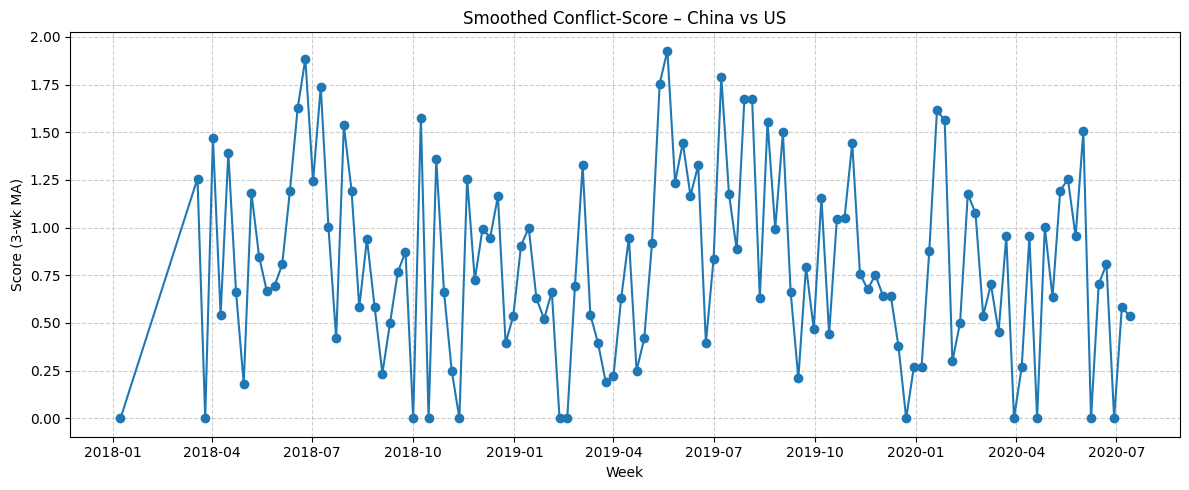

In [ ]:
# plot conflict-score
plt.figure(figsize=(12,5))
plt.plot(pair_df["week"], pair_df["conflict_score"], marker="o")
plt.title("Smoothed Conflict-Score – China vs US")
plt.xlabel("Week"); plt.ylabel("Score (3-wk MA)")
plt.grid(ls="--", alpha=.6); plt.tight_layout(); plt.show()


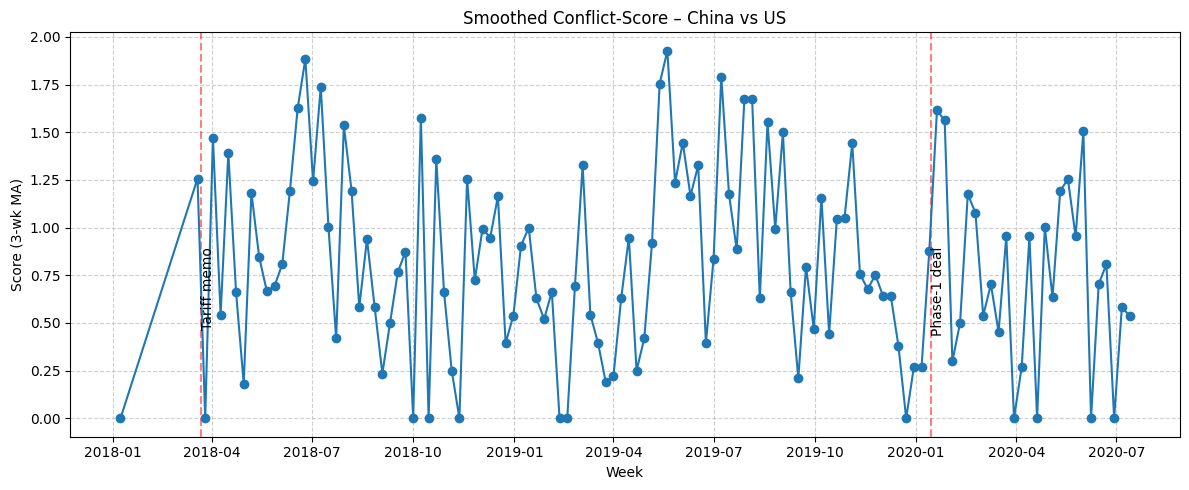

In [ ]:
plt.figure(figsize=(12,5))

# add event markers
events = {
    "2018-03-22": "Tariff memo",
    "2020-01-15": "Phase-1 deal",
}

for d, lbl in events.items():
    d = pd.to_datetime(d)
    plt.axvline(d, color="red", ls="--", alpha=.5)
    plt.text(d, 0.9, lbl, rotation=90, va="top")


plt.plot(pair_df["week"], pair_df["conflict_score"], marker="o")
plt.title("Smoothed Conflict-Score – China vs US")
plt.xlabel("Week"); plt.ylabel("Score (3-wk MA)")
plt.grid(ls="--", alpha=.6); plt.tight_layout(); plt.show()


plt.show()


In [ ]:
# benchmark vs GPR
import xlrd, textwrap

raw = pd.read_excel(GPR_FILE, engine="openpyxl")
raw["date"] = pd.to_datetime(raw["month"])
gpr = raw[~raw["GPR"].isna()][["date", "GPR"]]

gpr_w = (
    gpr.set_index("date")["GPR"]
        .resample("W-MON")
        .ffill()
)

merged = pair_df.set_index("week").join(gpr_w, how="inner")
print(merged[["conflict_score", "GPR"]].corr())


                conflict_score       GPR
conflict_score        1.000000  0.295879
GPR                   0.295879  1.000000


Correlation matrix:
                 conflict_score  GPR_week
conflict_score        1.000000  0.295879
GPR_week              0.295879  1.000000


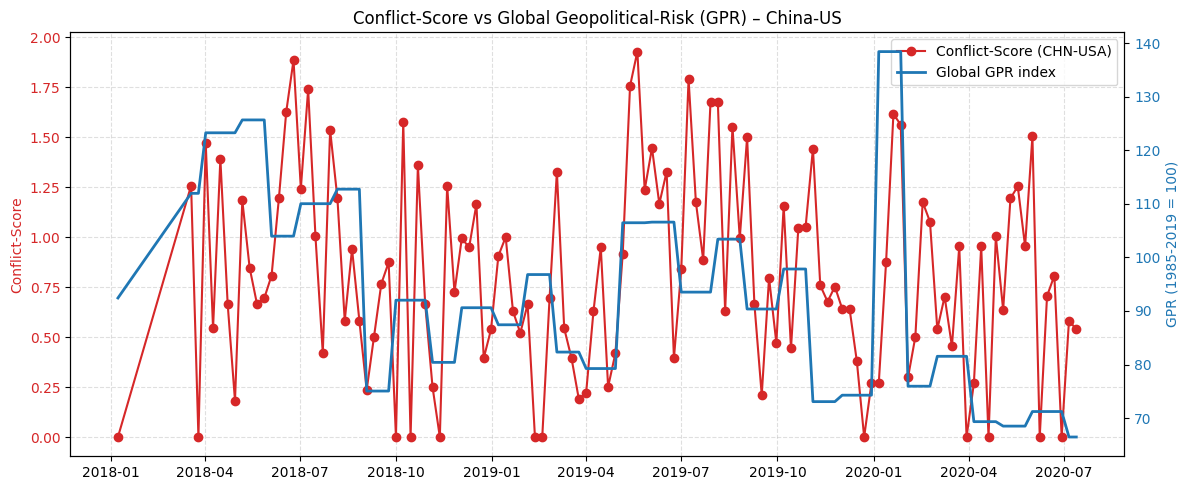

In [ ]:
# ---------- Cell 6 : benchmark vs GPR  +  overlay plot ----------
import pandas as pd, matplotlib.pyplot as plt, textwrap, xlrd

# 1) Load GPR Excel (your file from professor’s site)
gpr_raw = pd.read_excel(GPR_FILE)

# 2) Parse date column and keep the headline GPR index
gpr_raw["date"] = pd.to_datetime(gpr_raw["month"])          # 'month' column is "YYYY-MM-01"
gpr = gpr_raw.loc[~gpr_raw["GPR"].isna(), ["date", "GPR"]]

# 3) Resample to Monday-aligned ISO weeks
gpr_w = (
    gpr.set_index("date")["GPR"]
        .resample("W-MON")
        .ffill()
        .rename("GPR_week")
        .to_frame()
)

# 4) Merge with our conflict-score series
merged = (
    pair_df.set_index("week")[["conflict_score"]]
           .join(gpr_w, how="inner")
)

print("Correlation matrix:\n", merged.corr())

# 5) Plot both series on twin y-axes
fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(merged.index,
         merged["conflict_score"],
         color="#d62728", label="Conflict-Score (CHN-USA)", marker="o")
ax1.set_ylabel("Conflict-Score", color="#d62728")
ax1.tick_params(axis='y', labelcolor="#d62728")
ax1.grid(ls="--", alpha=.4)

ax2 = ax1.twinx()
ax2.plot(merged.index,
         merged["GPR_week"],
         color="#1f77b4", label="Global GPR index", linewidth=2)
ax2.set_ylabel("GPR (1985-2019 = 100)", color="#1f77b4")
ax2.tick_params(axis='y', labelcolor="#1f77b4")

# combine legends
lines  = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper right")

plt.title("Conflict-Score vs Global Geopolitical-Risk (GPR) – China-US")
plt.tight_layout()
plt.show()


Correlation matrix:
                 conflict_score  GPRC_CHN  GPRC_USA
conflict_score        1.000000  0.308638  0.310734
GPRC_CHN              0.308638  1.000000  0.798971
GPRC_USA              0.310734  0.798971  1.000000


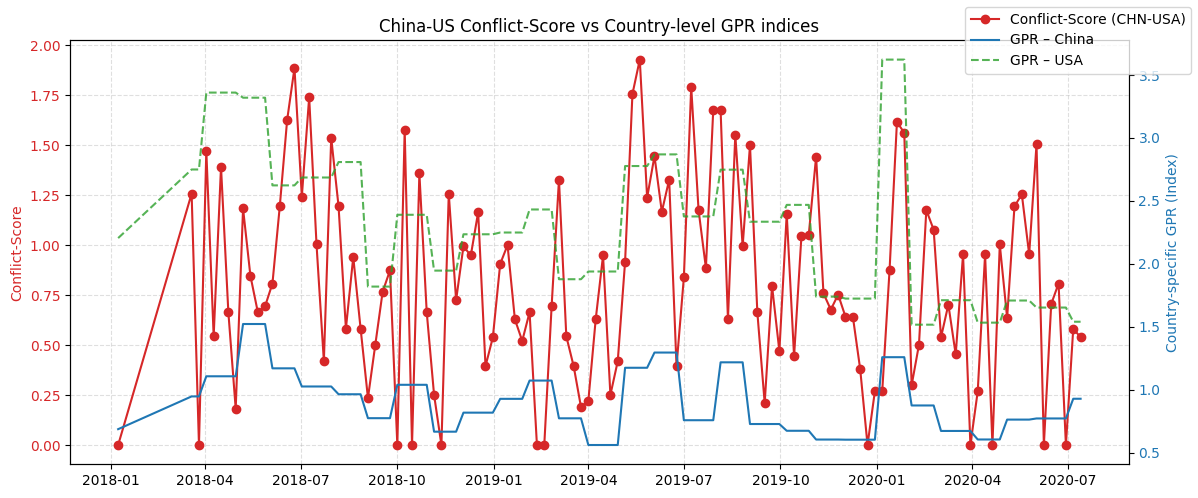

In [ ]:
# country-specific GPR vs Conflict-Score
import pandas as pd, matplotlib.pyplot as plt, xlrd

# 1) Load the Excel and extract the CHN and USA columns
gpr_raw = pd.read_excel(GPR_FILE)

# Parse date column
gpr_raw["date"] = pd.to_datetime(gpr_raw["month"])

# Keep only the two country-specific indices (drop NaNs)
cols = ["date", "GPRC_CHN", "GPRC_USA"]
gpr_cn_us = gpr_raw[cols].dropna(subset=["GPRC_CHN", "GPRC_USA"])

# 2) Resample to Monday-aligned ISO weeks
gpr_week = (
    gpr_cn_us.set_index("date")[["GPRC_CHN", "GPRC_USA"]]
             .resample("W-MON")
             .ffill()
)

# 3) Merge with conflict-score
merged = (
    pair_df.set_index("week")[["conflict_score"]]
           .join(gpr_week, how="inner")
)

print("Correlation matrix:\n", merged.corr())

# 4) Plot – three series, dual y-axes
fig, ax1 = plt.subplots(figsize=(12,5))

# conflict-score (left y-axis)
ax1.plot(merged.index,
         merged["conflict_score"],
         color="#d62728", marker="o", label="Conflict-Score (CHN-USA)")
ax1.set_ylabel("Conflict-Score", color="#d62728")
ax1.tick_params(axis='y', labelcolor="#d62728")
ax1.grid(ls="--", alpha=.4)

# twin axis for GPR
ax2 = ax1.twinx()
ax2.plot(merged.index,
         merged["GPRC_CHN"],
         color="#1f77b4", label="GPR – China")
ax2.plot(merged.index,
         merged["GPRC_USA"],
         color="#2ca02c", label="GPR – USA", alpha=.8, ls="--")
ax2.set_ylabel("Country-specific GPR (Index)", color="#1f77b4")
ax2.tick_params(axis='y', labelcolor="#1f77b4")

# combine legends
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
fig.legend(lines, labels, loc="upper right")

plt.title("China-US Conflict-Score vs Country-level GPR indices")
plt.tight_layout()
plt.show()


In [ ]:
# correlation with CHN- and USA-specific GPR
import xlrd, pandas as pd

# 1) Read the Excel and get date column
raw = pd.read_excel(GPR_FILE)
raw["date"] = pd.to_datetime(raw["month"])

# 2) Keep country-specific columns, drop rows where either is NaN
cols = ["date", "GPRC_CHN", "GPRC_USA"]
gpr_cn_us = raw[cols].dropna(subset=["GPRC_CHN", "GPRC_USA"])

# 3) Resample to Monday-aligned ISO weeks
gpr_w = (
    gpr_cn_us.set_index("date")[["GPRC_CHN", "GPRC_USA"]]
             .resample("W-MON")
             .ffill()
)

# 4) Merge with conflict-score DataFrame (pair_df comes from earlier cell)
merged = (
    pair_df.set_index("week")[["conflict_score"]]
           .join(gpr_w, how="inner")
)

# 5) Print correlations
corr = merged.corr()
print("Correlation with Conflict-Score (CHN-USA)")
print(corr.loc["conflict_score", ["GPRC_CHN", "GPRC_USA"]])


Correlation with Conflict-Score (CHN-USA)
GPRC_CHN    0.308638
GPRC_USA    0.310734
Name: conflict_score, dtype: float64
